In [2]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

2024-04-30 17:49:07.469762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 17:49:09.472141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/environment/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

data_path = '../data/processed/reviews_processed.csv'
df = pd.read_csv(data_path)
def convert_label(label):
    if label in [1, 2]:
        return 0  # 消极
    elif label == 3:
        return 1  # 中性
    else:
        return 2  # 积极

df['Label'] = df['Label'].apply(convert_label)

train_df, temp_test_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

def build_model(pretrained_model_name, add_bilstm=False, custom_tokenizer=None):
    if custom_tokenizer:
        tokenizer = AutoTokenizer.from_pretrained(custom_tokenizer)
    else:
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    
    base_model = TFAutoModel.from_pretrained(pretrained_model_name)

    input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(None,), dtype=tf.int32, name="attention_mask")
    
    outputs = base_model(input_ids, attention_mask=attention_mask)
    sequence_output = outputs.last_hidden_state
    
    if add_bilstm:
        x = Bidirectional(LSTM(256, return_sequences=True))(sequence_output)
        x = Bidirectional(LSTM(128, return_sequences=False))(x)
    else:
        x = sequence_output[:, 0, :]
    
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model, tokenizer

def prepare_data(tokenizer, df, max_length=128):
    encodings = tokenizer(df['Review'].tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")
    dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']},
        df['Label'].values
    ))
    dataset = dataset.batch(16)
    return dataset


In [ ]:

models = {
    'bert-base': ('bert-base-uncased', True, None),
    'distilbert-base': ('distilbert-base-uncased', True, None),
    'roberta-base': ('roberta-base', False, None),
    'custom-roberta-base': ('roberta-base', True, "cardiffnlp/twitter-roberta-base-sentiment-latest")
}

results = {}
histories = {}

def warmup_and_exponential_decay(epoch, start_lr, max_lr, warmup_epochs, decay_rate):
    if epoch < warmup_epochs:
        lr = start_lr + (max_lr - start_lr) / warmup_epochs * epoch
    else:
        lr = max_lr * decay_rate ** (epoch - warmup_epochs)
    return lr

warmup_and_expo_lr_scheduler = LearningRateScheduler(
    lambda epoch: warmup_and_exponential_decay(epoch, start_lr=5e-9, max_lr=1e-6, warmup_epochs=4, decay_rate=0.8),
    verbose=1
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label'].values
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

for name, (model_name, use_bilstm, tokenizer_name) in models.items():
    print(f"Training {name} model...")
    model, tokenizer = build_model(model_name, add_bilstm=use_bilstm, custom_tokenizer=tokenizer_name)
    train_dataset = prepare_data(tokenizer, train_df, max_length=128)
    val_dataset = prepare_data(tokenizer, val_df, max_length=128)
    test_dataset = prepare_data(tokenizer, test_df, max_length=128)

    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[warmup_and_expo_lr_scheduler],
        class_weight=class_weight_dict
    )
    histories[name] = history
    
    loss, accuracy = model.evaluate(test_dataset)
    predictions = model.predict(test_dataset)
    y_pred = predictions.argmax(axis=-1)
    y_true = test_df['Label'].values
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    results[name] = {'loss': loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

Training bert-base model...


2024-04-30 17:49:36.198880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:49:36.266505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 17:49:36.266806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf


Epoch 1: LearningRateScheduler setting learning rate to 5e-09.
Epoch 1/50


2024-04-30 17:50:13.358163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-30 17:50:14.383878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2024-04-30 17:50:15.121986: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x258ab910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 17:50:15.122060: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-30 17:50:15.250560: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-30 17:50:15.914263: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

928/928 [==============================] - 264s 233ms/step - loss: 1.1280 - accuracy: 0.2107 - val_loss: 1.1479 - val_accuracy: 0.2180 - lr: 5.0000e-09

Epoch 2: LearningRateScheduler setting learning rate to 2.5375e-07.
Epoch 2/50
928/928 [==============================] - 168s 181ms/step - loss: 1.0255 - accuracy: 0.5169 - val_loss: 0.8107 - val_accuracy: 0.7329 - lr: 2.5375e-07

Epoch 3: LearningRateScheduler setting learning rate to 5.025e-07.
Epoch 3/50
928/928 [==============================] - 167s 180ms/step - loss: 0.6830 - accuracy: 0.7812 - val_loss: 0.4469 - val_accuracy: 0.8315 - lr: 5.0250e-07

Epoch 4: LearningRateScheduler setting learning rate to 7.5125e-07.
Epoch 4/50
928/928 [==============================] - 162s 175ms/step - loss: 0.5155 - accuracy: 0.8292 - val_loss: 0.3876 - val_accuracy: 0.8519 - lr: 7.5125e-07

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/50
928/928 [==============================] - 164s 177ms/step - loss: 0.4529 - ac

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



Epoch 1: LearningRateScheduler setting learning rate to 5e-09.
Epoch 1/50
928/928 [==============================] - 161s 149ms/step - loss: 1.1003 - accuracy: 0.3048 - val_loss: 1.0926 - val_accuracy: 0.3235 - lr: 5.0000e-09

Epoch 2: LearningRateScheduler setting learning rate to 2.5375e-07.
Epoch 2/50
928/928 [==============================] - 99s 106ms/step - loss: 1.0098 - accuracy: 0.5817 - val_loss: 0.8316 - val_accuracy: 0.7212 - lr: 2.5375e-07

Epoch 3: LearningRateScheduler setting learning rate to 5.025e-07.
Epoch 3/50
928/928 [==============================] - 100s 107ms/step - loss: 0.6858 - accuracy: 0.7797 - val_loss: 0.4801 - val_accuracy: 0.8153 - lr: 5.0250e-07

Epoch 4: LearningRateScheduler setting learning rate to 7.5125e-07.
Epoch 4/50
928/928 [==============================] - 99s 107ms/step - loss: 0.5330 - accuracy: 0.8173 - val_loss: 0.4199 - val_accuracy: 0.8367 - lr: 7.5125e-07

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/50
928/9

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe


Epoch 1: LearningRateScheduler setting learning rate to 5e-09.
Epoch 1/50
928/928 [==============================] - 240s 218ms/step - loss: 1.2049 - accuracy: 0.6163 - val_loss: 0.9391 - val_accuracy: 0.6240 - lr: 5.0000e-09

Epoch 2: LearningRateScheduler setting learning rate to 2.5375e-07.
Epoch 2/50
928/928 [==============================] - 121s 130ms/step - loss: 1.0753 - accuracy: 0.5769 - val_loss: 0.9721 - val_accuracy: 0.6704 - lr: 2.5375e-07

Epoch 3: LearningRateScheduler setting learning rate to 5.025e-07.
Epoch 3/50
928/928 [==============================] - 120s 129ms/step - loss: 0.6475 - accuracy: 0.7732 - val_loss: 0.3656 - val_accuracy: 0.8563 - lr: 5.0250e-07

Epoch 4: LearningRateScheduler setting learning rate to 7.5125e-07.
Epoch 4/50
928/928 [==============================] - 121s 130ms/step - loss: 0.4634 - accuracy: 0.8472 - val_loss: 0.3300 - val_accuracy: 0.8776 - lr: 7.5125e-07

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/50
928

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe


Epoch 1: LearningRateScheduler setting learning rate to 5e-09.
Epoch 1/50
928/928 [==============================] - 247s 221ms/step - loss: 1.1155 - accuracy: 0.6070 - val_loss: 1.0288 - val_accuracy: 0.6066 - lr: 5.0000e-09

Epoch 2: LearningRateScheduler setting learning rate to 2.5375e-07.
Epoch 2/50
928/928 [==============================] - 156s 168ms/step - loss: 0.9833 - accuracy: 0.6495 - val_loss: 0.5921 - val_accuracy: 0.7967 - lr: 2.5375e-07

Epoch 3: LearningRateScheduler setting learning rate to 5.025e-07.
Epoch 3/50
928/928 [==============================] - 156s 168ms/step - loss: 0.5681 - accuracy: 0.8171 - val_loss: 0.3814 - val_accuracy: 0.8571 - lr: 5.0250e-07

Epoch 4: LearningRateScheduler setting learning rate to 7.5125e-07.
Epoch 4/50
928/928 [==============================] - 157s 169ms/step - loss: 0.4514 - accuracy: 0.8520 - val_loss: 0.3527 - val_accuracy: 0.8695 - lr: 7.5125e-07

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/50
928

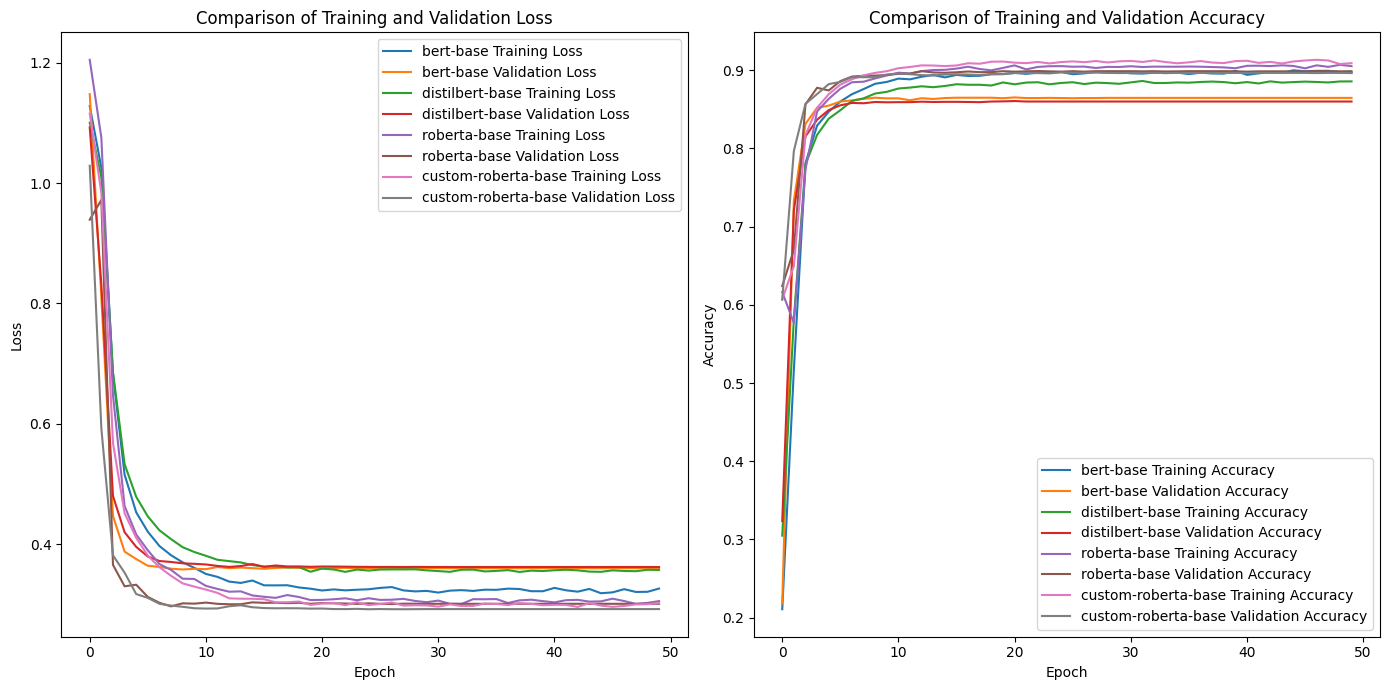

bert-base - Loss: 0.3415830135345459, Accuracy: 0.8696706295013428, Precision: 0.879343081547811, Recall: 0.8696706405334411, F1 Score: 0.873369733855848
distilbert-base - Loss: 0.35072916746139526, Accuracy: 0.864821195602417, Precision: 0.877715210629999, Recall: 0.8648211759951505, F1 Score: 0.869568324847749
roberta-base - Loss: 0.2880507504940033, Accuracy: 0.8974045467376709, Precision: 0.9027577585932588, Recall: 0.8976045261669024, F1 Score: 0.9002205196759858
custom-roberta-base - Loss: 0.280903697013855, Accuracy: 0.8985653519630432, Precision: 0.903847428572444, Recall: 0.8986921600323297, F1 Score: 0.9006135293891714


In [5]:

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')
plt.title('Comparison of Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')
plt.title('Comparison of Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

for name, result in results.items():
    print(f"{name} - Loss: {result['loss']}, Accuracy: {result['accuracy']}, Precision: {result['precision']}, Recall: {result['recall']}, F1 Score: {result['f1']}")

In [7]:
import pandas as pd

for name, history in histories.items():
    df = pd.DataFrame({
        'Training Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss'],
        'Training Accuracy': history.history['accuracy'],
        'Validation Accuracy': history.history['val_accuracy']
    })
    df.to_csv(f'{name}_history.csv', index=False)  # 保存为CSV文件

for name, result in results.items():
    result_df = pd.DataFrame([result])
    result_df.to_csv(f'{name}_performance.csv', index=False)  


In [8]:
for name, (model_name, use_bilstm, tokenizer_name) in models.items():
    model_path = f'{name}_model.h5' 
    model.save(model_path)  
    print(f"Model saved at {model_path}")


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at bert-base_model.h5
Model saved at distilbert-base_model.h5
Model saved at roberta-base_model.h5
Model saved at custom-roberta-base_model.h5
